# LSTM

In [1]:
from conx import Network, LSTMLayer, Layer
import numpy as np
import matplotlib.pyplot as plt

Using Theano backend.


In [2]:
%matplotlib inline

In [3]:
# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 1
# number of elements ahead that are used to make the prediction
lahead = 1

In [4]:
def gen_cosine_amp(amp=100, period=1000, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos

In [5]:
print('Generating Data...')
cos = gen_cosine_amp()
print('Input shape:', cos.shape)

expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

print('Output shape:', expected_output.shape)

Generating Data...
Input shape: (50000, 1, 1)
Output shape: (50000, 1)


In [6]:
print('Creating Model...')
net = Network("LSTM")
net.add(Layer("input", (1, 1), batch_shape=(25, 1, 1))) 
net.add(LSTMLayer("lstm1",
                  50,
                  batch_size=25,
                  return_sequences=True,
                  stateful=True))
net.add(LSTMLayer("lstm2",
                  50,
                  return_sequences=False,
                  stateful=True))
net.add(Layer("output", 1))
net.connect()
net.compile(loss='mse', optimizer='rmsprop')

Creating Model...


In [7]:
net

ValueError: Shape mismatch: x has 25 rows but z has 1 rows
Apply node that caused the error: Gemm{no_inplace}(Subtensor{::, int64::}.0, TensorConstant{0.20000000298023224}, lstm1/variable[t-1], <TensorType(float32, matrix)>, TensorConstant{0.20000000298023224})
Toposort index: 5
Inputs types: [TensorType(float32, matrix), TensorType(float32, scalar), TensorType(float32, matrix), TensorType(float32, matrix), TensorType(float32, scalar)]
Inputs shapes: [(1, 50), (), (25, 50), (50, 50), ()]
Inputs strides: [(800, 4), (), (200, 4), (800, 4), ()]
Inputs values: ['not shown', array(0.20000000298023224, dtype=float32), 'not shown', 'not shown', array(0.20000000298023224, dtype=float32)]
Outputs clients: [[Elemwise{Composite{(clip((i0 + i1), i2, i3) * tanh(i4))}}(TensorConstant{(1, 1) of 0.5}, Gemm{no_inplace}.0, TensorConstant{(1, 1) of 0}, TensorConstant{(1, 1) of 1}, Elemwise{Composite{((clip((i0 + i1), i2, i3) * i4) + (clip((i5 + i6), i2, i3) * tanh(i7)))}}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: forall_inplace,cpu,scan_fn}(TensorConstant{1}, InplaceDimShuffle{1,0,2}.0, IncSubtensor{InplaceSet;:int64:}.0, IncSubtensor{InplaceSet;:int64:}.0, TensorConstant{1}, Subtensor{::, int64:int64:}.0, Subtensor{::, :int64:}.0, Subtensor{::, int64:int64:}.0, Subtensor{::, int64::}.0)
Toposort index: 77
Inputs types: [TensorType(int64, scalar), TensorType(float32, (True, False, False)), TensorType(float32, 3D), TensorType(float32, 3D), TensorType(int64, scalar), TensorType(float32, matrix), TensorType(float32, matrix), TensorType(float32, matrix), TensorType(float32, matrix)]
Inputs shapes: [(), (1, 1, 200), (2, 25, 50), (2, 25, 50), (), (50, 50), (50, 50), (50, 50), (50, 50)]
Inputs strides: [(), (800, 800, 4), (5000, 200, 4), (5000, 200, 4), (), (800, 4), (800, 4), (800, 4), (800, 4)]
Inputs values: [array(1), 'not shown', 'not shown', 'not shown', array(1), 'not shown', 'not shown', 'not shown', 'not shown']
Outputs clients: [[Subtensor{int64}(forall_inplace,cpu,scan_fn}.0, Constant{1})], [Subtensor{int64}(forall_inplace,cpu,scan_fn}.1, Constant{1})], [InplaceDimShuffle{1,0,2}(forall_inplace,cpu,scan_fn}.2)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

<Network name='LSTM' (compiled)>

In [9]:
net.dataset.load_direct(cos, expected_output)

In [10]:
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)

    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in cos.
    # Each of these series are offset by one step and can be
    # extracted with cos[i::batch_size].

    net.train(batch_size=batch_size,
              epochs=1,
              shuffle=False)
    net.model.reset_states()

Training
Epoch 0 / 1
Training...
Epoch 1/1
50000/50000 [==============================] - 5s - loss: 337.9365 - acc: 0.0000e+00     
Epoch #    1 | train error 337.93646 | train accuracy 0.00000 | validate% 0.03124


In [11]:
print('Predicting')
predicted_output = net.model.predict(cos, batch_size=batch_size)

Predicting


Plotting Results


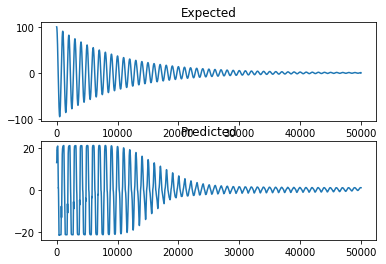

In [12]:
print('Plotting Results')
plt.subplot(2, 1, 1)
plt.plot(expected_output)
plt.title('Expected')
plt.subplot(2, 1, 2)
plt.plot(predicted_output)
plt.title('Predicted')
plt.show()